In [2]:
import os

# set the environment variable to control the number of threads
# NEEDS TO BE DONE BEFORE CCL IS IMPORTED
original_omp_num_threads = os.environ.get('OMP_NUM_THREADS', None)
os.environ['OMP_NUM_THREADS'] = '1'

import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import emcee
import parallelbar
import corner

import src.datamaker as dm

from scipy.interpolate import interp1d
from scipy.integrate import simps

from multiprocessing import Pool, cpu_count

from time import time, sleep
from importlib import reload
reload(dm)

<module 'src.datamaker' from '/home/b7009348/CosyMAML/src/datamaker.py'>

In [3]:
def Smail_dndz(z, z0, alpha):
    return z**2 * np.exp(-(z/z0)**alpha)

def convolve_photoz(sigma, zs, dndz_spec, return_2d=False):

     # Convolve with photo-z
    sigma_z = sigma * (1 + zs)

    z_ph = np.linspace(0.05, 4.0, 300)

    # find probability of galaxy with true redshift z_s to be measured at redshift z_ph
    integrand1 = np.zeros([len(zs),len(z_ph)])
    p_zs_zph = np.zeros([len(zs),len(z_ph)])
    for j in range(len(zs)):
        p_zs_zph[j,:] =  (1. / (np.sqrt(2. * np.pi) * sigma_z[j])) * np.exp(-((z_ph - zs[j])**2) / (2. * sigma_z[j]**2))

    integrand1 = p_zs_zph * dndz_spec[:,None]   

    # integrate over z_s to get dN
    integral1 = simps(integrand1, zs, axis=0)
    dN = integral1
    
    dz_ph = simps(dN, z_ph)

    if return_2d:
        return z_ph, dN/dz_ph, p_zs_zph
    
    return z_ph, dN/dz_ph

CDF values: [0.  0.2 0.4 0.6 0.8 1. ]
Bin edges (z): [0.18947578 0.39363876 0.57691157 0.79459246 1.12462992 2.74449819]


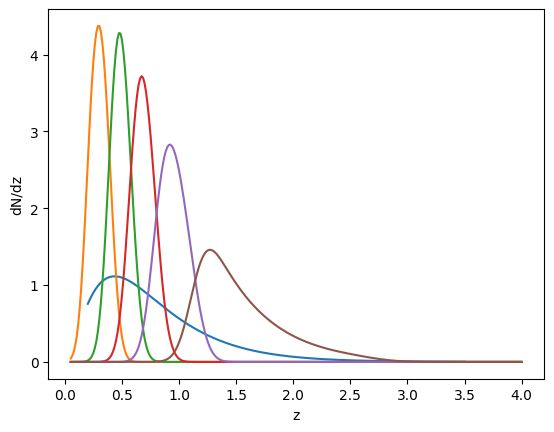

In [4]:
# Generate the redshift distribution
z = np.linspace(0.2, 3.5, 300)
z0 = 0.13
alpha = 0.78

def Smail_dndz(z, z0, alpha):
    return z**2 * np.exp(-(z/z0)**alpha)

dndz_s = Smail_dndz(z, z0, alpha)

# Normalize the distribution
area = simps(dndz_s, z)  # Integrate dndz_s over z to get the area under the curve
pdf = dndz_s / area  # Normalize to make it a PDF

# Compute the cumulative distribution function (CDF)
cdf = np.cumsum(pdf) * (z[1] - z[0])  # Approximate the integral to get the CDF

# Interpolate the CDF to find the bin edges
inverse_cdf = interp1d(cdf, z, fill_value="extrapolate")

n_bins = 5

# Define the CDF values for the bin edges
cdf_values = np.linspace(0, 1, n_bins+1)
print("CDF values:", cdf_values)
# Find the corresponding z values (bin edges) for these CDF values
bin_edges = inverse_cdf(cdf_values)

# Print the bin edges
print("Bin edges (z):", bin_edges)

plt.figure()
plt.plot(z, pdf, label='True dndz')

zs = []
dndz_spec_bins = []
dndz_ph_bins = []
for i in range(n_bins):
    zs.append(np.linspace(bin_edges[i], bin_edges[i+1], len(z)))
    dndz_spec_bins.append(Smail_dndz(zs[i], z0, alpha)) # Store spec bins to produce slighty different photo-z bins later

    z_ph, dndz_ph = convolve_photoz(0.05, zs[i], dndz_spec_bins[i])
    dndz_ph_bins.append(dndz_ph) # fiducial photo-z bins

    # Norm with respect to full dndz
    plt.plot(z_ph, dndz_ph_bins[i], label='Photo-z convolved')
    plt.xlabel('z')
    plt.ylabel('dN/dz')

Mean before shift: 1.5302188913708175
Mean after shift: 1.6302188913708175
Delta z: 0.10000000000000009


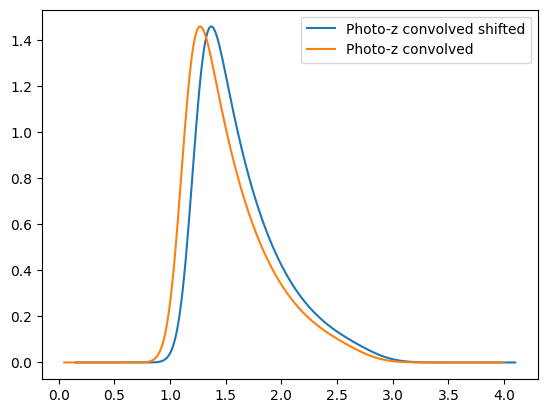

In [5]:
# Try to shift the mean
delta_z = 0.1
mean = np.average(z_ph, weights=dndz_ph)
z_ph_shifted = z_ph + delta_z#*(1 + mean)
z_ph_shifted[z_ph_shifted < 0] = 0

mean_shifted = np.average(z_ph_shifted, weights=dndz_ph)
print("Mean before shift:", mean)
print("Mean after shift:", mean_shifted)
print("Delta z:", mean_shifted - mean)

plt.plot(z_ph_shifted, dndz_ph, label='Photo-z convolved shifted')
plt.plot(z_ph, dndz_ph, label='Photo-z convolved')
plt.legend()

Text(0.5, 1.0, 'LSST Y1 photo-z model')

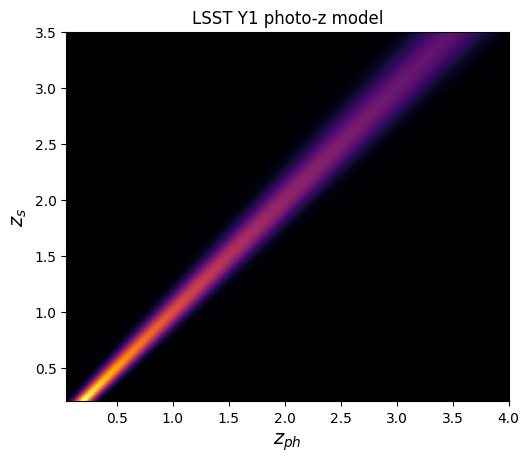

In [6]:
z_ph, dndz_ph, pz_s_zph = convolve_photoz(0.05, z, pdf, return_2d=True)

plt.imshow(pz_s_zph, aspect='equal', extent=[0.05, 4.0, 0.2, 3.5], origin='lower', cmap='inferno')
plt.xlabel(r'$z_{ph}$', fontsize=14)
plt.ylabel(r'$z_s$', fontsize=14)
plt.title('LSST Y1 photo-z model')

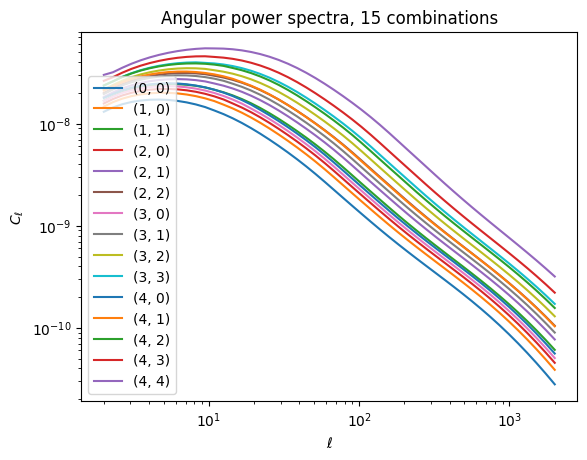

In [7]:
# Create mock observational data
# Define the cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96, matter_power_spectrum='halofit')

ells = np.geomspace(2, 2000)

# Compute auto and cross spectra
indices = np.tril_indices(n_bins)
zipped_inds = list(zip(*indices))

plt.figure()
c_ells = np.empty((len(zipped_inds), len(ells)))
for i, arg in enumerate(zipped_inds):
    j, k = arg
    tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[j]))
    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[k]))
    c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells, l_limber='auto')
    plt.loglog(ells, c_ells[i], label=f'({j}, {k})', ls='-')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_\ell$')
    plt.legend()
    plt.title('Angular power spectra, {} combinations'.format(len(zipped_inds)))

Text(0.5, 1.0, 'Emulated Data Vector, $C^{ij}_\\ell$')

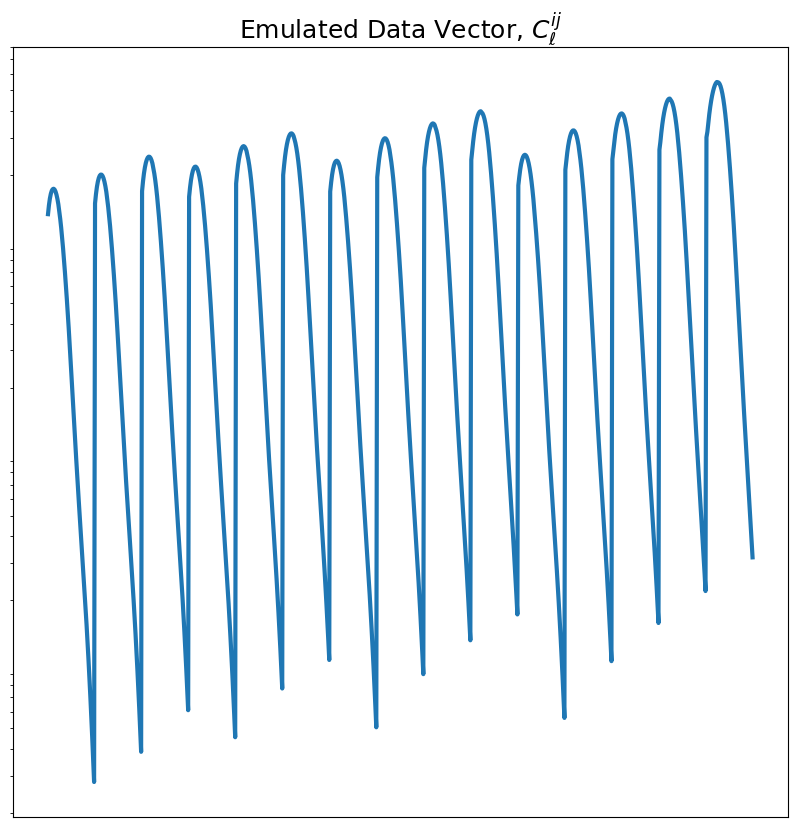

In [10]:
data_vector = c_ells.flatten() # Flatten the array to make it a vector

# Add noise
noise = 1e-6 * data_vector
data_vector += np.random.normal(0, noise)

# generate covariance matrix
cov = np.diag(noise**2)
inv_cov = np.linalg.inv(cov)


plt.figure(figsize=(10,10))
plt.plot(data_vector, lw=3)
plt.xticks([])
plt.yscale('log')
plt.yticks([])
plt.title('Emulated Data Vector, $C^{ij}_\ell$', fontsize=18)

In [ ]:
# Define the likelihood function
def log_likelihood(theta, data, inv_cov):
    cosmo = ccl.Cosmology(Omega_c=theta[0], Omega_b=theta[1], h=theta[2], sigma8=theta[3], n_s=theta[4], matter_power_spectrum='halofit')
    model = np.empty((len(zipped_inds), len(ells)))

    # Shift mean of photo-z bins based on theta
    shifted_z = [] 
    for i in range(n_bins):
        mean_z = np.average(z, weights=dndz_ph_bins[i])
        shifted_z.append(z + theta[5+i]*(1 + mean_z))
        # set any negative values to 0
        shifted_z[i][shifted_z[i] < 0] = 0

    for i, arg in enumerate(zipped_inds):
        j, k = arg
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(shifted_z[j], dndz_ph_bins[j]))
        tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(shifted_z[k], dndz_ph_bins[k]))
        model[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells, l_limber='auto')

    model_vector = model.flatten()
    diff = data - model_vector
    return -0.5 * np.dot(diff, np.dot(inv_cov, diff))

def log_prior(theta, priors):
    for i, prior in enumerate(priors):
        if not prior[0] < theta[i] < prior[1]:
            return -np.inf
    return 0.0

def log_probability(theta, data, cov, priors):
    lp = log_prior(theta, priors)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, data, cov)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [ ]:
np.random.seed(14)

theta = [0.27, 0.045, 0.67, 0.83, 0.96, 0.00, 0.00] # fiducial cosmology

# Initialize the walkers
nwalkers = 32
ndim = len(theta)
chain_len = 100

# Initialize the walkers in a tiny Gaussian ball around the maximum likelihood result
pos = theta + 1e-4 * np.random.randn(nwalkers, ndim)
priors = [(0.1, 0.9), (0.01, 0.1), (0.5, 0.9), (0.7, 1.0), (0.8, 1.1), (-0.002, 0.002), (-0.002, 0.002)]

# test the likelihood function
start = time()
ln_likelihood = log_probability(theta, data_vector, inv_cov, priors)
end = time()
print("Log likelihood: {}".format(ln_likelihood))
print("Time taken: {}s".format(end - start))

-76.70248425553993
Log likelihood: -76.70248425553993
Time taken: 1.5391664505004883s


In [ ]:
converged = False

backend = emcee.backends.HDFBackend("test.h5")
backend.reset(nwalkers, ndim)

# Initialise a pool 
with Pool(cpu_count()) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=(data_vector, inv_cov, priors),
        pool=pool,
        backend=backend,

    )
    
    while not converged:
        
        # Sample 
        start = time()
        sampler.run_mcmc(pos, chain_len, progress=True)
        end = time()

        # Update the initial positions
        pos = sampler.get_last_sample()

        # Check convergence
        tau = sampler.get_autocorr_time(tol=0)
        converged = np.all(tau * 50 < sampler.iteration)
        print("Current iteration: {}".format(sampler.iteration))
        print("Autocorrelation times: {}".format(tau*50))

        # Estimate completion time
        time_per_iter = (end - start) / sampler.iteration
        time_left = (np.max(tau) * (chain_len - sampler.iteration)) * time_per_iter
        print("Estimated time left: {}s".format(time_left))

TypeError: EnsembleSampler.__init__() got an unexpected keyword argument 'store_blobs'

In [ ]:
# Create hypercube of parameters to train an emulator

# Define the parameter space
# Priors from DES Y3 Cosmic shear fits
OmM = np.array([0.1, 0.9])
OmB = np.array([0.03, 0.07])
OmC = OmM - OmB

h = np.array([0.55, 0.91])
n_s = np.array([0.87, 1.07])
sigma8 = np.array([0.6, 0.9])

# Generate the hypercube
n_points = 1000
cosmo_hypercube = dm.gen_hypercube(
    Omega_c=OmC,
    Omega_b=OmB,
    h=h,
    sigma8=sigma8,
    n_s=n_s,
    n_samples=n_points
)

args = [
        (
            cosmo_hypercube[i,0],
            cosmo_hypercube[i,1],
            cosmo_hypercube[i,2],
            cosmo_hypercube[i,3],
            cosmo_hypercube[i,4],
            zipped_inds,
            ells,
            z,
            dndz_ph_bins
        ) for i in range(n_points)
    ]

# Compute C_ell for each point in the hypercube in parallel
def compute_cl(Omega_b, Omega_c, h, sigma8, n_s, zipped_inds, ells, z, dndz_ph_bins):
    cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s)
    c_ells = np.empty((len(zipped_inds), len(ells)))
    for i, arg in enumerate(zipped_inds):
        j, k = arg
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[j]))
        tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz_ph_bins[k]))
        c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells)
        
    return c_ells.flatten()

# Compute the C_ell for each point in the hypercube using parallelbar
n_cores = cpu_count()

c_ells_train = parallelbar.progress_starmap(compute_cl, args, n_cpu=n_cores)

DONE:   0%|          | 0/10000 [00:00<?, ?it/s]

(12000, 40, 7)


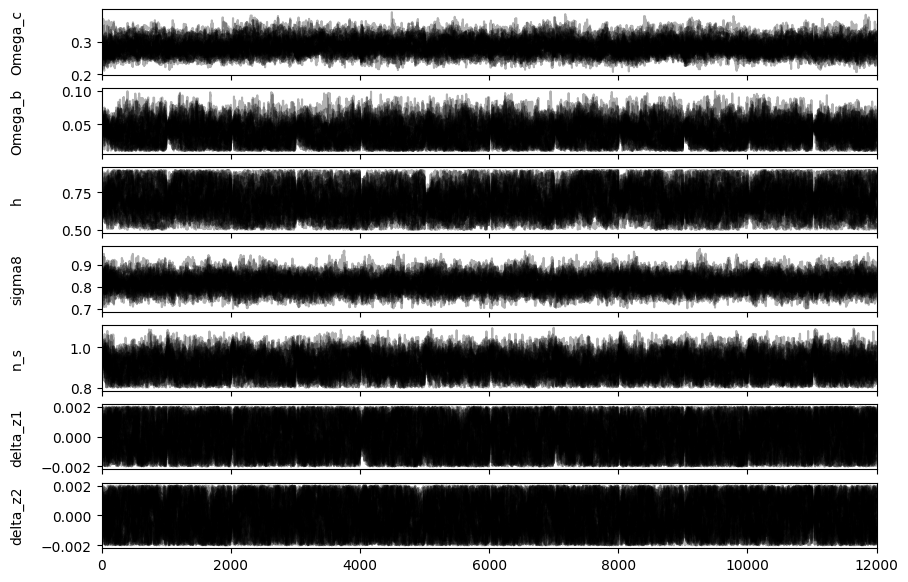

In [ ]:
# Test loading data from the backend
reader = emcee.backends.HDFBackend("mcmc/40walkers_chain_outputs.h5")

# Get the chain
samples = reader.get_chain()
print(samples.shape)
ndim = 7

# Plot the chain
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
labels = ["Omega_c", "Omega_b", "h", "sigma8", "n_s", "delta_z1", "delta_z2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [ ]:
flat_samples = reader.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[0.27, 0.045, 0.67, 0.83, 0.96, 0.00, 0.00]
);

(29320, 7)
